In [1]:
from gensim.models import KeyedVectors
import numpy as np
from matplotlib import pyplot as plt
import random

In [2]:
from numpy import dot
from numpy.linalg import norm
def project(word, axis):
    return dot(word, axis) / norm(axis)

In [3]:
def smooth(data, window = 1):
    result = [np.mean(data[max(0, i - window) : min(len(data) - 1, i + window) + 1]) for i in range(len(data))]

    return np.array(result)

In [4]:
# Get projections of enhanced I-tokens on axis
def get_proj(axis, mn, mx):
    results_m = [project(model[f'я_м_{age}'], axis) for age in range(mn, mx)]
    results_w = [project(model[f'я_ж_{age}'], axis) for age in range(mn, mx)]

    return np.array(results_w), np.array(results_m)

In [5]:
def get_axis(women_adj, men_adj):
    men_adj_av = np.mean([model[word] for word in men_adj], axis = 0)
    women_adj_av = np.mean([model[word] for word in women_adj], axis = 0)
    return women_adj_av - men_adj_av

# Generate a random axis by shuffling lists of words
def get_random_axis(women_adj, men_adj):
    all_words = [word for word in women_adj] + [word for word in men_adj]
    random.shuffle(all_words)
    men_adj_r = all_words[:28]
    women_adj_r = all_words[28:]
   
    return get_axis(women_adj_r, men_adj_r)

In [6]:
# Compute bias by averaging women and men I-tokens and projecting them to a given axis
def get_bias(axis, mn, mx):
    women = np.mean([model['я_ж_' + str(i)] for i in range(mn, mx)], axis = 0)
    men = np.mean([model['я_м_' + str(i)] for i in range(mn, mx)], axis = 0)
    return project(women, axis) - project(men, axis)

# Compute bias for sublists of varying length as suggested in 
# M. Spliethöver, H. Wachsmuth (2021). Bias silhouette analysis: Towards assessing the quality of bias metrics for word embedding models. In
def get_voc_bias(women_adj, men_adj, mn, mx):
    result = []

    random.shuffle(men_adj)
    random.shuffle(women_adj)
    
    for i in range(1, 30):
        smpl_m = men_adj[:i]
        smpl_w = women_adj[:i]

        axis = get_axis(smpl_w, smpl_m)

        result.append(get_bias(axis, mn, mx))
    return result

In [7]:
orange = '#E76F51'
green = '#2A9D8F'
black = '#2d2d2d'
blue = '#325BF1'

In [8]:
women_adj = ['болтливый', 'мягкосердечный', 'зависимый', 'женственный', 'ласковый', 'обаятельный', 'плаксивый', 'непостоянный', 'суетливый', 'возбудимый', 'сентиментальный', 'эмоциональный', 'покорный', 'мечтательный', 'чувствительный', 'благодарный', 'кроткий', 'слабый', 'жалующийся', 'привлекательный', 'нежный', 'нервный', 'чувственный', 'утонченный', 'придирчивый', 'кокетливый', 'легкомысленный']
men_adj =['жесткий', 'уверенный', 'предприимчивый', 'устойчивый', 'рациональный', 'реалистичный', 'жестокий', 'беспорядочный', 'бесстрастный', 'громкий', 'грубый', 'автократический', 'агрессивный', 'напористый', 'логичный', 'невозмутимый', 'дерзкий', 'крепкий', 'честолюбивый', 'самоуверенный', 'независимый', 'сильный', 'властный', 'мужественный', 'хвастливый', 'суровый', 'веселый', 'авантюрный']

In [9]:
# Minimum and maximum age for plotting
mn, mx = 14, 51

In [10]:
model_file = 'model'
model = KeyedVectors.load('model.bin', mmap='r').wv

In [11]:
axis = get_axis(women_adj, men_adj)

In [12]:
# Simulating projection to random axes
sim_w = []
sim_m = []
random.seed(3)

for i in range(1000):
    axis_r = get_random_axis(women_adj, men_adj)
    w, m = get_proj(axis_r, mn, mx)
    sim_w.append(w)
    sim_m.append(m)

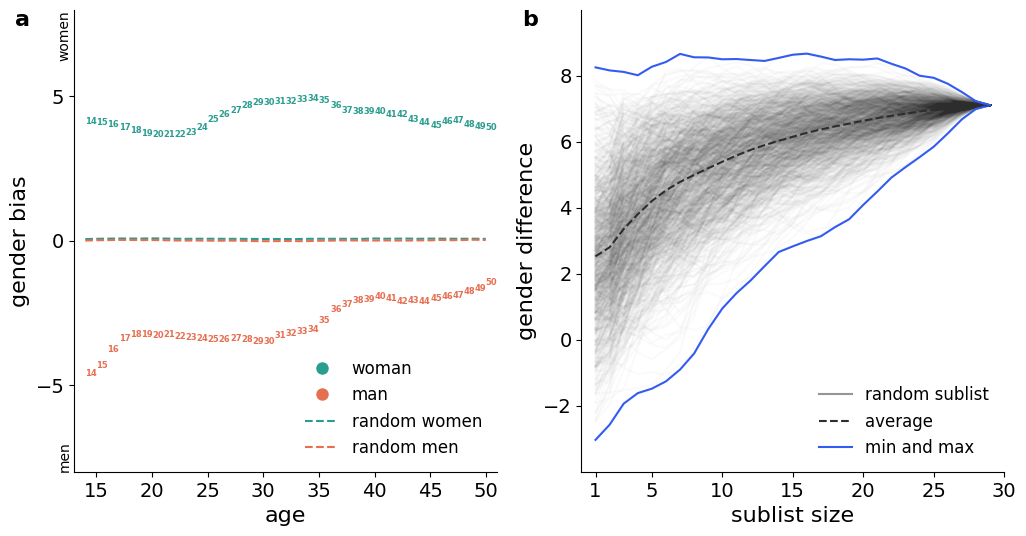

In [13]:
w, m = get_proj(axis, mn, mx)
w = smooth(w)
m = smooth(m)

plt.figure(figsize = (12, 6))

plt.subplot(1, 2, 1)

for i, age in enumerate(range(14, 51)):
    plt.text(age, w[i], str(age), color = green, size = 6, weight = 'bold', alpha = 1)
    plt.text(age, m[i], str(age), color = orange, size = 6, weight = 'bold', alpha = 1)

plt.text(11.5, 8, 'women', size = 10, rotation = 90, va = 'top')
plt.text(11.5, -8, 'men', size = 10, rotation = 90, va = 'bottom')

plt.plot([], [], color = 'white', marker = 'o', markerfacecolor = green, markersize = 10, label = 'woman')
plt.plot([], [], color = 'white', marker = 'o', markerfacecolor = orange, markersize = 10, label = 'man')

plt.plot(range(mn, mx), np.mean(sim_w, axis = 0), '--', color = green, label = 'random women')
plt.plot(range(mn, mx), np.mean(sim_m, axis = 0), '--', color = orange, label = 'random men')

plt.xlim(13, 51)
plt.ylim(-8, 8)
plt.xlabel('age', size = 16)
plt.ylabel('gender bias', size = 16)
plt.legend(frameon = False, prop = {'size': 12}, loc='lower right')
plt.xticks(size = 14)
plt.yticks([-5, 0, 5], size = 14)
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)

ax.text(-0.14, 1, 'a', ha = 'left', va = 'top', transform=ax.transAxes, size = 16, weight='bold')

plt.subplot(1, 2, 2)

plt.plot([100,100], [200, 200], color = black, alpha = 0.5, label = 'random sublist')

# Simulating and plotting results for sublists of varying length
sim_results = []
for i in range(1000):
    result = get_voc_bias(women_adj, men_adj, mn, mx)
    sim_results.append(result)
    plt.plot(range(1, 30), smooth(result), color = black, alpha = 0.02)

plt.plot(range(1, 30), smooth(np.min(sim_results, axis = 0)),color = blue)
plt.plot(range(1, 30), smooth(np.mean(sim_results, axis = 0)), '--', color = black, label = 'average')
plt.plot(range(1, 30), smooth(np.max(sim_results, axis = 0)),color = blue, label = 'min and max')

plt.xlim(0, 30)
plt.ylim(-4, 10)
plt.xlabel('sublist size', size = 16)
plt.ylabel('gender difference', size = 16)
plt.legend(frameon = False, prop = {'size': 12})
plt.xticks([1, 5, 10, 15, 20, 25, 30], size = 14)
plt.yticks([-2, 0, 2, 4, 6, 8], size = 14)
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)

ax.text(-0.14, 1, 'b', ha = 'left', va = 'top', transform=ax.transAxes, size = 16, weight='bold');

#plt.tight_layout()
#plt.savefig('figure2.pdf')